In [2]:
import pandas as pd
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import numpy as np
import nltk
from nltk import word_tokenize, pos_tag
from nltk.chunk import RegexpParser
from tabulate import tabulate
from matplotlib import colors as mcolors



In [3]:
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\renhu\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [13]:
# Load and clean data function
def load_and_clean_data(file_path, remove_addresses=None):
    df = pd.read_csv(file_path, encoding='ISO-8859-1')
    
    df['CreatedDate'] = pd.to_datetime(df['CreatedDate'], format='%Y-%m-%dT%H:%M:%S.%f%z', errors='coerce')
    
    df = df.dropna(subset=['FromAddress', 'Subject', 'TextBody'])
    df = df[df['FromAddress'].str.strip() != '']
    df = df[df['Subject'].str.strip() != '']
    df = df[df['TextBody'].str.strip() != '']
    
    if remove_addresses:
        df = df[~df['FromAddress'].isin(remove_addresses)]
    
    df = df.sort_values(by='CreatedDate').drop_duplicates(subset='ParentId', keep='first')
    
    return df


In [14]:
# File paths and addresses to remove
spam_file_path = 'Your Spam Cases.csv'
non_spam_file_path = 'Your Non Spam Cases.csv'
remove_addresses = ['your_email_address@to_remove.com']

# Load and clean spam and non-spam data
df_spam = load_and_clean_data(spam_file_path, remove_addresses=remove_addresses)
df_non_spam = load_and_clean_data(non_spam_file_path)

In [18]:
# Count occurrences of email addresses in Spam Reporting
email_counts_spam = df_spam['FromAddress'].value_counts()
email_counts_non_spam = df_non_spam['FromAddress'].value_counts()

In [19]:
# Count occurrences of domains in Spam Reporting
df_spam['Domain'] = df_spam['FromAddress'].apply(lambda x: x.split('@')[1] if '@' in x else 'unknown')
df_non_spam['Domain'] = df_non_spam['FromAddress'].apply(lambda x: x.split('@')[1] if '@' in x else 'unknown')
domain_counts_spam = df_spam['Domain'].value_counts()
domain_counts_non_spam = df_non_spam['Domain'].value_counts()

In [17]:
# Identify top 20 email addresses and domains in Spam Reporting
top_email_addresses_spam = df_spam['FromAddress'].value_counts().head(20)
df_spam['Domain'] = df_spam['FromAddress'].apply(lambda x: x.split('@')[1] if '@' in x else 'unknown')
top_domains_spam = df_spam['Domain'].value_counts().head(20)

In [20]:
# Count occurrences of these addresses and domains in Non Spam Reporting
email_counts_non_spam = df_non_spam['FromAddress'].value_counts()
domain_counts_non_spam = df_non_spam['FromAddress'].apply(lambda x: x.split('@')[1] if '@' in x else 'unknown').value_counts()


In [21]:
# Create DataFrames for export
email_df = pd.DataFrame({
    'Email Address': email_counts_spam.index,
    'Count of Spam Email Address': email_counts_spam.values,
    'Count of Non Spam Email Address': email_counts_non_spam.reindex(email_counts_spam.index, fill_value=0).values
})

domain_df = pd.DataFrame({
    'Domain': domain_counts_spam.index,
    'Count of Spam Domain': domain_counts_spam.values,
    'Count of Non Spam Domain': domain_counts_non_spam.reindex(domain_counts_spam.index, fill_value=0).values
})

# Export to CSV
email_df.to_csv('email_counts.csv', index=False)
domain_df.to_csv('domain_counts.csv', index=False)

print("CSVs saved successfully.")

CSVs saved successfully.


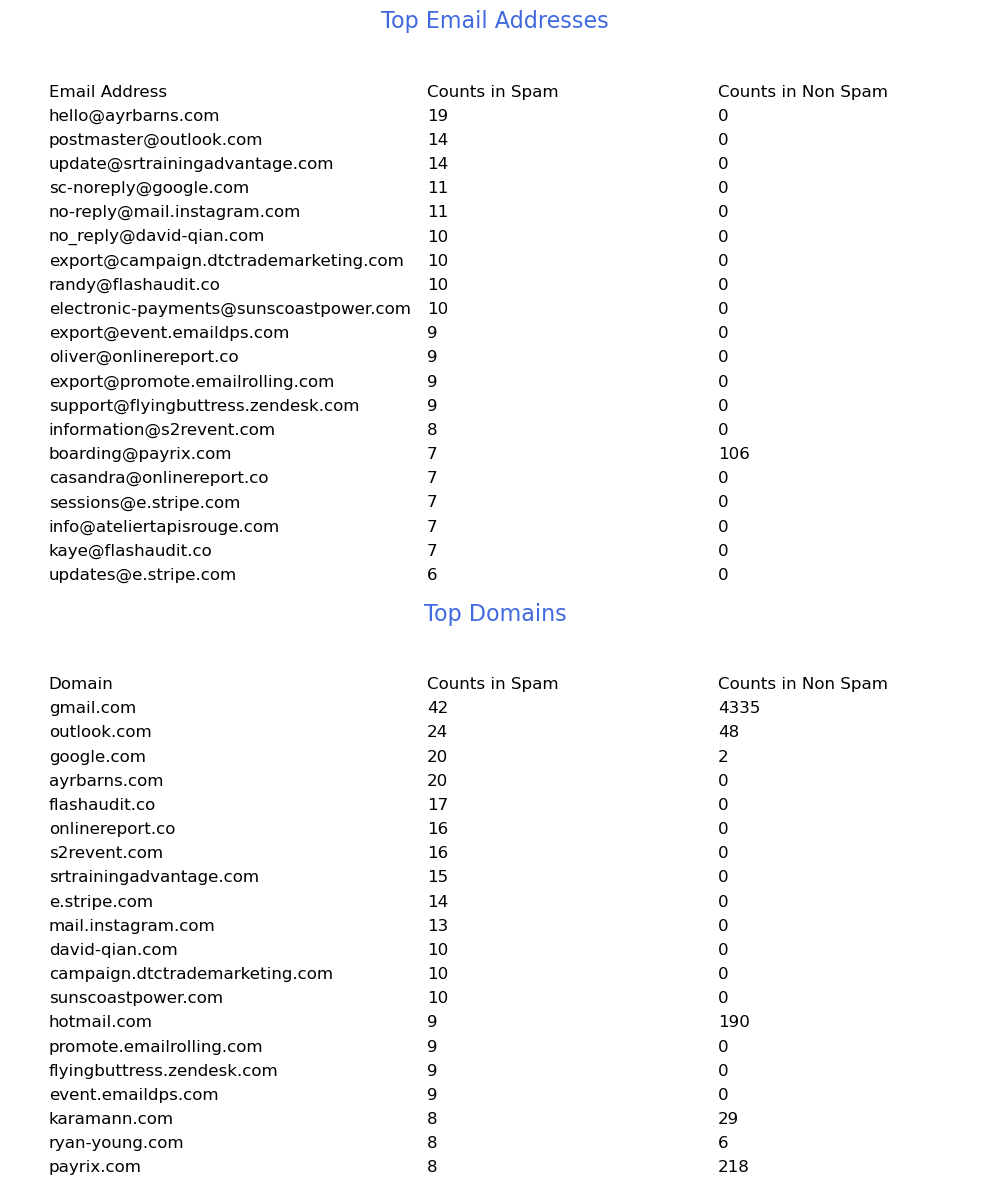

In [10]:
# Prepare data for tabular display
email_data = {
    'Email Address': top_email_addresses_spam.index,
    'Counts in Spam': top_email_addresses_spam.values,
    'Counts in Non Spam': [email_counts_non_spam.get(email, 0) for email in top_email_addresses_spam.index]
}

domain_data = {
    'Domain': top_domains_spam.index,
    'Counts in Spam': top_domains_spam.values,
    'Counts in Non Spam': [domain_counts_non_spam.get(domain, 0) for domain in top_domains_spam.index]
}

# Create a figure and axis for plotting
fig, axs = plt.subplots(nrows=2, figsize=(10, 12))

# Function to format the table cells with alternating row colors
def format_table(ax, data, title):
    ax.axis('off')
    table_data = []
    headers = list(data.keys())
    table_data.append(headers)
    for i in range(len(data[headers[0]])):
        row = []
        for header in headers:
            row.append(data[header][i])
        table_data.append(row)
    
    cell_colors = [[mcolors.CSS4_COLORS['white']] * len(headers) for _ in range(len(table_data))]
    
    table = ax.table(cellText=table_data,
                     colLabels=headers,
                     cellLoc='left',
                     loc='center',
                     cellColours=cell_colors,
                     colColours=[mcolors.CSS4_COLORS['lightblue']] * len(headers),
                     colWidths=[0.4, 0.3, 0.3],
                     edges='open',
                     bbox=[0, 0, 1, 1])
    
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.2, 1.2)
    ax.set_title(title, fontsize=16, pad=20, color=mcolors.CSS4_COLORS['royalblue'])
    
    # Add frame lines around the table
    for key, cell in table.get_celld().items():
        cell.set_edgecolor('lightgrey')
        cell.set_linewidth(0.5)
        cell.set_alpha(0.5)
    
    # Add border line around the table
    ax.spines['top'].set_linewidth(0.5)
    ax.spines['bottom'].set_linewidth(0.5)
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['right'].set_linewidth(0.5)
    ax.spines['top'].set_color('lightgrey')
    ax.spines['bottom'].set_color('lightgrey')
    ax.spines['left'].set_color('lightgrey')
    ax.spines['right'].set_color('lightgrey')
    
    # Remove duplicate header row
    for key, cell in table.get_celld().items():
        if key[0] == 0:
            cell.set_visible(False)
    
    return table

# Plot for Email Addresses
format_table(axs[0], email_data, 'Top Email Addresses')
format_table(axs[1], domain_data, 'Top Domains')

plt.tight_layout()
plt.show()

In [11]:
# Display results
print("Top 20 Email Addresses in Spam Reporting:")
print(top_email_addresses_spam)
print("\nCounts in Non Spam Reporting:")
print(email_counts_non_spam.reindex(top_email_addresses_spam.index, fill_value=0))

print("\nTop 20 Domains in Spam Reporting:")
print(top_domains_spam)
print("\nCounts in Non Spam Reporting:")
print(domain_counts_non_spam.reindex(top_domains_spam.index, fill_value=0))

Top 20 Email Addresses in Spam Reporting:
hello@ayrbarns.com                        19
postmaster@outlook.com                    14
update@srtrainingadvantage.com            14
sc-noreply@google.com                     11
no-reply@mail.instagram.com               11
no_reply@david-qian.com                   10
export@campaign.dtctrademarketing.com     10
randy@flashaudit.co                       10
electronic-payments@sunscoastpower.com    10
export@event.emaildps.com                  9
oliver@onlinereport.co                     9
export@promote.emailrolling.com            9
support@flyingbuttress.zendesk.com         9
information@s2revent.com                   8
boarding@payrix.com                        7
casandra@onlinereport.co                   7
sessions@e.stripe.com                      7
info@ateliertapisrouge.com                 7
kaye@flashaudit.co                         7
updates@e.stripe.com                       6
Name: FromAddress, dtype: int64

Counts in Non Spam Report

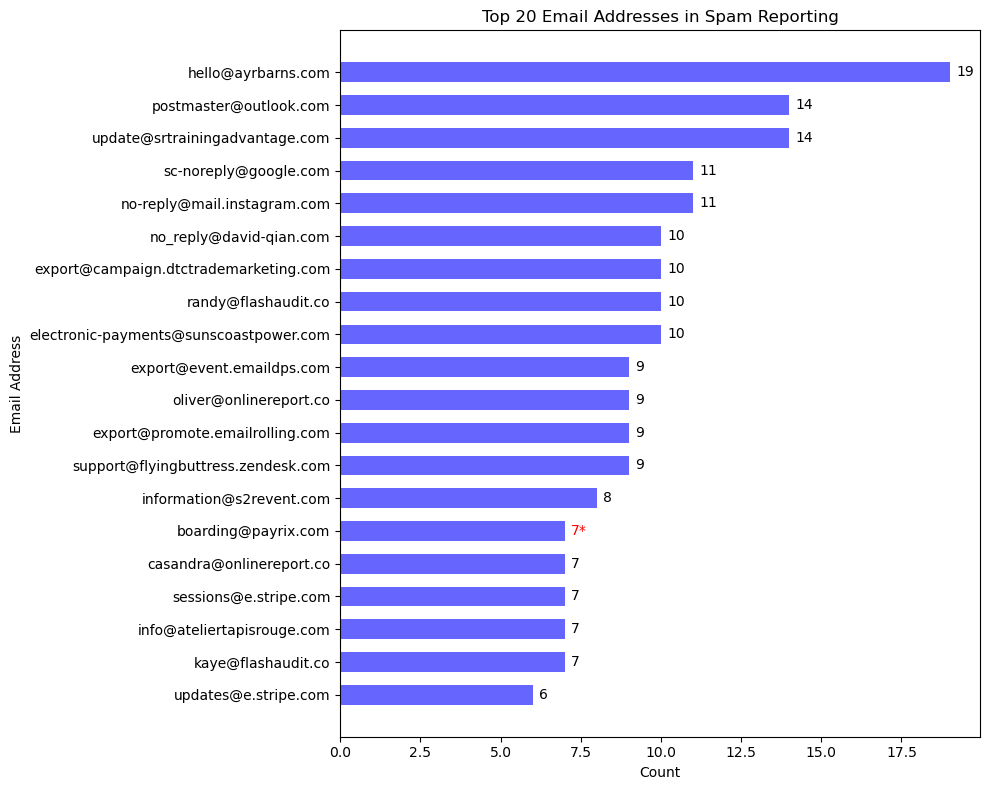

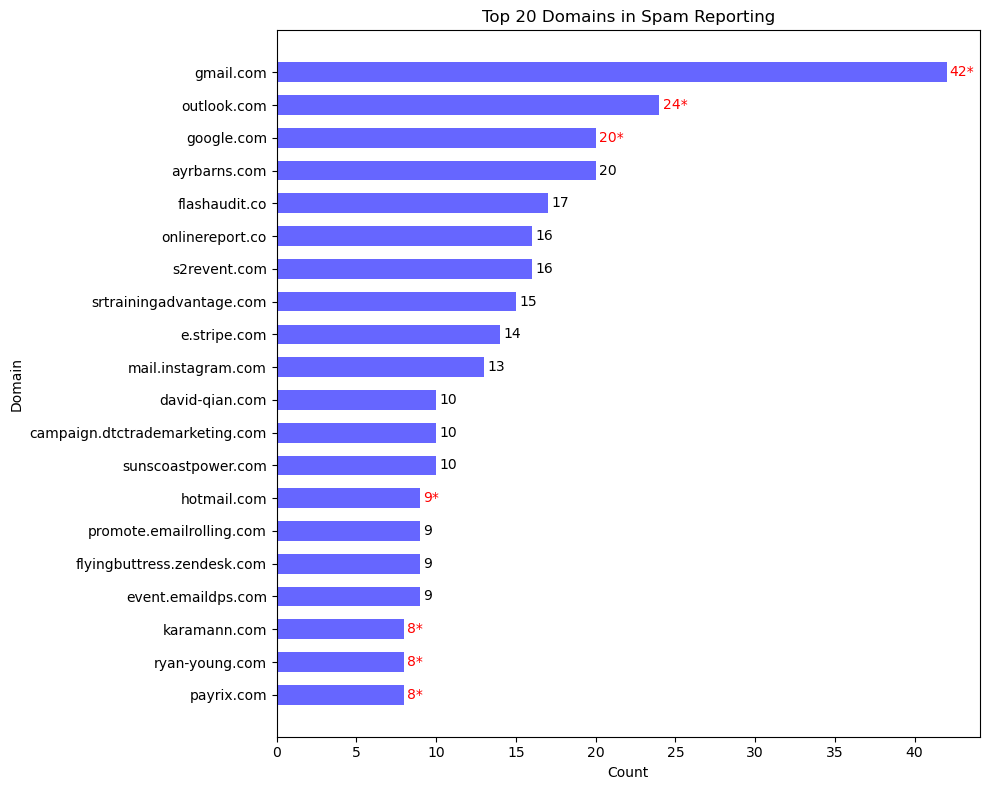

In [12]:
# Select top addresses and domains from spam and their counts in non-spam
top_email_addresses = top_email_addresses_spam.index
top_domains = top_domains_spam.index

email_counts_spam = top_email_addresses_spam.reindex(top_email_addresses, fill_value=0)
domain_counts_spam = top_domains_spam.reindex(top_domains, fill_value=0)

# Plotting side by side bars in one figure
plt.figure(figsize=(10, 8))

# Plot for top email addresses
bar_width = 0.6
index = np.arange(len(top_email_addresses))

# Bar for email addresses
bars = plt.barh(index, email_counts_spam.values, bar_width, color='b', alpha=0.6)

# Add stars for email addresses with non-zero counts in non-spam reporting
for i, email in enumerate(top_email_addresses):
    if email_counts_non_spam.get(email, 0) > 0:
        plt.text(email_counts_spam[email] + 0.2, i, f'{email_counts_spam[email]}*', va='center', fontsize=10, color='red')
    else:
        plt.text(email_counts_spam[email] + 0.2, i, f'{email_counts_spam[email]}', va='center', fontsize=10)

plt.xlabel('Count')
plt.ylabel('Email Address')
plt.title('Top 20 Email Addresses in Spam Reporting')
plt.yticks(index, top_email_addresses)
plt.gca().invert_yaxis()  # Invert y-axis to display highest count at the top

plt.tight_layout()
plt.show()

# Plot for top domains
plt.figure(figsize=(10, 8))

# Bar for domains
bars = plt.barh(index, domain_counts_spam.values, bar_width, color='b', alpha=0.6)

# Add stars for domains with non-zero counts in non-spam reporting
for i, domain in enumerate(top_domains):
    if domain_counts_non_spam.get(domain, 0) > 0:
        plt.text(domain_counts_spam[domain] + 0.2, i, f'{domain_counts_spam[domain]}*', va='center', fontsize=10, color='red')
    else:
        plt.text(domain_counts_spam[domain] + 0.2, i, f'{domain_counts_spam[domain]}', va='center', fontsize=10)

plt.xlabel('Count')
plt.ylabel('Domain')
plt.title('Top 20 Domains in Spam Reporting')
plt.yticks(index, top_domains)
plt.gca().invert_yaxis()  # Invert y-axis to display highest count at the top

plt.tight_layout()
plt.show()

In [55]:
# Custom tokenizer function to exclude tokens containing digits
def custom_tokenizer(text):
    tokens = re.findall(r'\b(?:[a-zA-Z]+(?:[a-zA-Z]+[\'\-]?[a-zA-Z]+)*)\b', text.lower())  # Tokenize by words (excluding numbers)
    return tokens

In [25]:
# Function to extract 2 or 3 word phrases from text
def extract_specific_phrases(text):
    tokens = word_tokenize(text)
    tagged_tokens = pos_tag(tokens)
    
    # Define a grammar for chunking 2 or 3 word phrases (NP)
    grammar = r"""
        NP: {<DT>?<JJ>*<NN>}      # chunk determiner/adj+noun
            {<DT>?<JJ>*<NNP>*}    # chunk determiner/adj+noun+proper noun
            {<RB>?<VB.*><RP>*}    # chunk adverbs/verbs/adverb phrases
    """
    
    # Create a chunk parser using the defined grammar
    chunk_parser = RegexpParser(grammar)
    
    # Apply chunking to the tagged tokens
    parsed_text = chunk_parser.parse(tagged_tokens)
    
    # Extract phrases based on the defined grammar
    phrases = []
    for subtree in parsed_text.subtrees():
        if subtree.label() == 'NP':  # Adjust labels based on your grammar
            # Filter for 2 or 3 word phrases
            if len(subtree.leaves()) == 2 or len(subtree.leaves()) == 3:
                phrases.append(' '.join(word for word, tag in subtree.leaves()))
    
    return phrases

In [26]:
# Difine new file paths for NLP and Pattern Identification
file_path = 'Your Spam Cases.csv'
file_path_non = 'Your Non Spam Cases.csv'

# Load and clean data
df = load_and_clean_data(file_path)
df_non = load_and_clean_data(file_path_non)

# Apply extraction function to 'Subject' and 'TextBody' columns
extracted_phrases = []
for text in df['Subject']:
    extracted_phrases.extend(extract_specific_phrases(text))

for text in df['TextBody']:
    extracted_phrases.extend(extract_specific_phrases(text))


# Count phrase frequencies
phrase_counts = Counter(extracted_phrases)

In [94]:
# Get top phrases
top_phrases = phrase_counts.most_common(100)

# Print top 50 to 100 phrases if they exist
if len(top_phrases) >= 100:
    print("Top 50 to 100 Phrases from Spam Reporting:")
    for rank, (phrase, count) in enumerate(top_phrases[51:100], start=52):
        print(f"{rank}. {phrase}: {count}")
else:
    print("There are not enough phrases to print the top 50 to 100.")

Top 50 to 100 Phrases from Spam Reporting:
52. hereby notified: 41
53. STUDIO DESIGNER SRL: 40
54. This e-mail: 40
55. n't delivered: 40
56. not pass: 40
57. a DMARC: 40
58. compauth=fail reason=000: 40
59. > MIME-Version: 40
60. AmazonSES X-SES-Outgoing: 40
61. amazonses.com X-EOPAttributedMessage: 40
62. EE_ X-MS-Office365-Filtering-Correlation-Id: 40
63. this week: 39
64. charset=iso-8859-1 Feedback-ID: 39
65. kelly @: 37
66. not be: 36
67. * Please: 36
68. b-wdesign.com P: 36
69. the Marketing Director: 35
70. the message: 34
71. KBD Staffing: 32
72. this communication: 32
73. Bianca Martins: 32
74. katie @ katiebaldwindesigns.com: 32
75. Katie @: 32
76. 860-596-4421 *: 32
77. Bianca Martin: 32
78. Millerton Road Please: 32
79. 596-4421 Cell: 32
80. 523-8395 Email: 32
81. The information: 30
82. High Point: 29
83. mc_eid=UNIQID https: 29
84. this transmission: 28
85. the studio: 28
86. Kate Taylor: 26
87. the email: 26
88. not have: 26
89. > Sent: 25
90. the home: 24
91. the futur

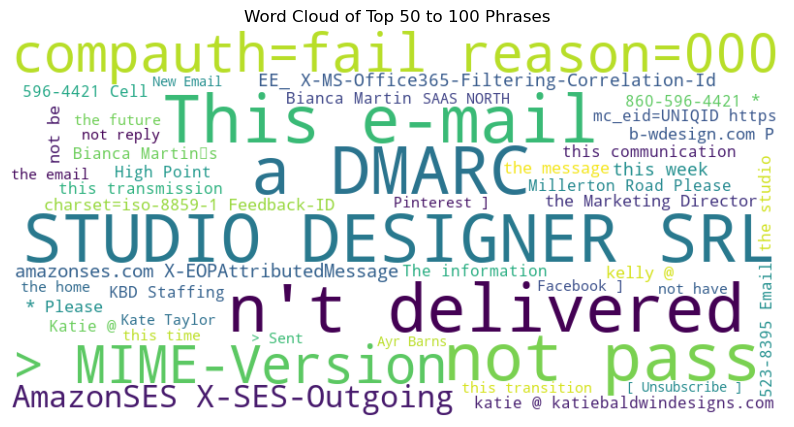

In [96]:
# Generate Word Cloud for top 50 to 100 phrases
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(top_phrases[52:100]))

# Display the Word Cloud
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Top 50 to 100 Phrases')
plt.show()

In [97]:
# Summarize the intentions of the spam emails
intentions = ['win', 'prize', 'free', 'urgent', 'limited time', 'offer', 'click here', 'buy now', 'congratulations']
intention_counts = Counter()

for intention in intentions:
    intention_counts[intention] = df['TextBody'].str.contains(intention, case=False, na=False).sum()

most_popular_intention = intention_counts.most_common(1)

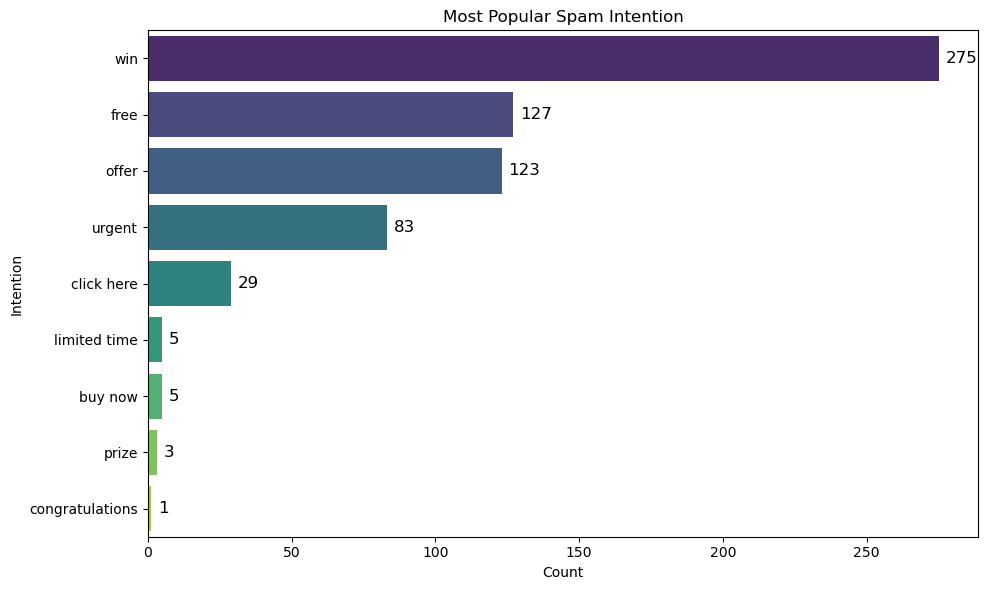

In [132]:
# Most Popular Spam Intention
intention_df = pd.DataFrame(intention_counts.items(), columns=['Intention', 'Count']).sort_values(by='Count', ascending=False)

# Plotting with Seaborn
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Count', y='Intention', data=intention_df, palette='viridis')

# Adding annotations
for p in ax.patches:
    ax.annotate(f'{int(p.get_width())}',  # Convert width to integer
                (p.get_width(), p.get_y() + p.get_height() / 2),
                ha='left', va='center',
                fontsize=12, color='black', xytext=(5, 0),
                textcoords='offset points')

plt.title('Most Popular Spam Intention')
plt.xlabel('Count')
plt.ylabel('Intention')
plt.tight_layout()
plt.show()

In [99]:
# Perform sentiment analysis
df['Sentiment'] = df['TextBody'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
sentiment_counts = df['Sentiment'].apply(lambda x: 'Positive' if x > 0 else 'Negative' if x < 0 else 'Neutral').value_counts()

In [27]:
# Perform sentiment analysis
df_non['Sentiment'] = df_non['TextBody'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
sentiment_counts_non = df_non['Sentiment'].apply(lambda x: 'Positive' if x > 0 else 'Negative' if x < 0 else 'Neutral').value_counts()

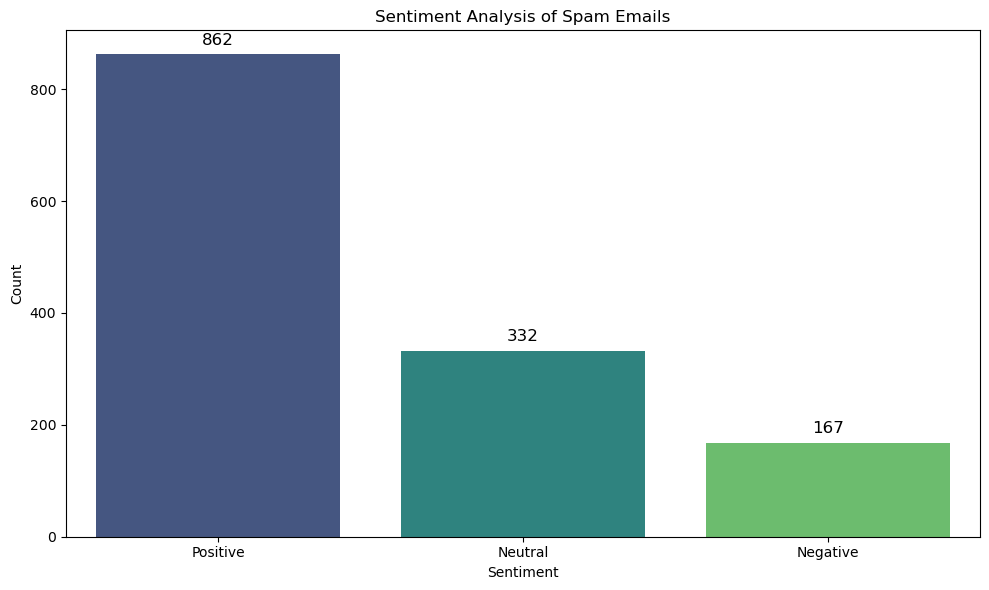

In [134]:
# Plotting with Seaborn
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')

# Adding annotations
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom',
                fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.title('Sentiment Analysis of Spam Emails')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

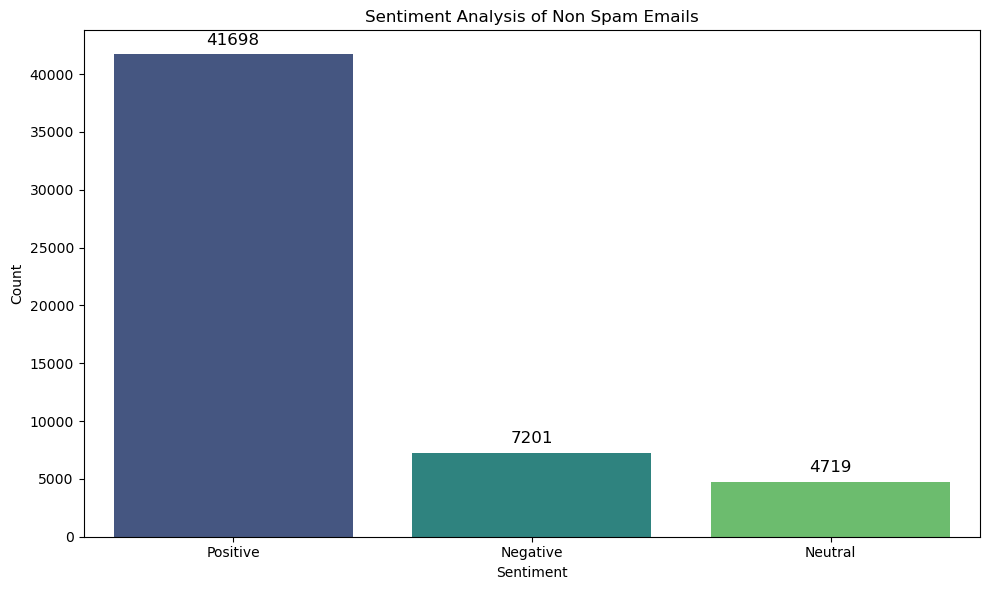

In [28]:
# Plotting with Seaborn
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=sentiment_counts_non.index, y=sentiment_counts_non.values, palette='viridis')

# Adding annotations
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom',
                fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.title('Sentiment Analysis of Non Spam Emails')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.tight_layout()
plt.show()